<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Laboratory Task 2
</p>

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Contents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Posters Classification</a></li>
        <li><a href="#002">Synopsis Classification</a></li>
        <li><a href="#003">Title Classification</a></li>
        <li><a href="#004">Validation</a></li>
        <li><a href="#005">Multimodal Classification</a></li>
    </ol>
</div>

In [1]:
# !pip install catalyst transformers

In [2]:
import os
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings(action="ignore")

In [3]:
from catalyst import dl
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import torchvision

import shap
import time
import numpy as np
import pandas as pd
from PIL import Image
from __future__ import annotations
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Posters Classification
        </p>
    </a>
</blockquote>

**imdb_dataset.csv** сontains useful information:
- **id** (string) - unique identifier of the title
- **title** (string) – title used by the filmmakers on promotional materials
- **synopsis** (string) – short description of the film from the filmmakers
- **poster_path** (string) – path to the downloaded film poster image
- **genre** (string) – genre associated with the title
- **label** (int) – unique identifier associated with the genre

In [4]:
class PostersDataset(Dataset):
    def __init__(self, annotation: pd.DataFrame, transforms: callable | None = None) -> None:
        """
        Args:
            annotation (pd.DataFrame): Pandas dataframe with annotation.
            transform (callable, optional): Optional transform object.
        """
        self.annotation = annotation
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.annotation)
    
    def __getitem__(self, index: int) -> dict:
        image_name = self.annotation.loc[index, "poster_path"]
        image = Image.open(image_name).convert("RGB")
        
        label = self.annotation.loc[index, "label"].astype(torch.LongTensor)
        
        sample = {"features": image, "targets": label}
        
        # Image augmentation is recommended.
        # See more: https://pytorch.org/vision/master/transforms.html.
        if self.transforms:
            sample = {"features": self.transforms(image), "targets": label}
        
        return sample

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [6]:
dataset = pd.read_csv("imdb_dataset.csv")
train_data, test_data = train_test_split(dataset, train_size=0.75, shuffle=True)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [7]:
train_dataset = PostersDataset(annotation=train_data, transforms=transforms)
test_dataset = PostersDataset(annotation=test_data, transforms=transforms)

In [8]:
loaders = {
    "train": torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True),
    "valid": torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False),
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Short | Superhero | Western | Documentary | Superhero | Horror | Film-Noir | Western | Film-Noir | Film-Noir | Animation | Animation | Horror | Comedy | Fantasy | Western | Musical | Animation | Family | Superhero | Animation | Thriller | Adventure | Comedy | Horror | Short | Sport | Film-Noir | History | Biography | Action | Sci-Fi


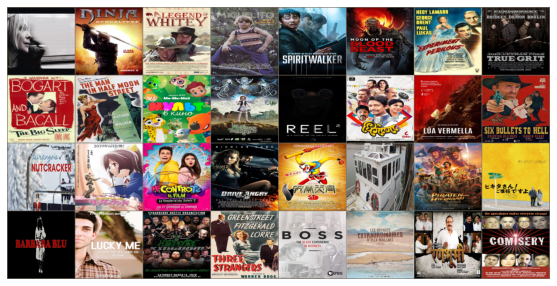

In [9]:
classes = [
    "Romance", "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary",
    "Drama", "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Superhero",
    "Musical", "Mystery", "Sci-Fi", "Sport", "Thriller", "War", "Western", "Short"
]


def plot_dataloader(dataloader):
    images, labels = dataloader["features"], dataloader["targets"]
    images = torchvision.utils.make_grid(images).numpy()
    images = np.transpose(images, axes=(1, 2, 0))
    images = np.array([0.229, 0.224, 0.225]) * images + np.array([0.485, 0.456, 0.406])
    
    print(" | ".join(f"{classes[int(labels[i])]}" for i in range(32)))
    plt.figure(figsize=(15, 5))
    plt.imshow(images)
    plt.axis("off")
    plt.show()

plot_dataloader(next(iter(loaders["train"])))

Training dataset: 4860


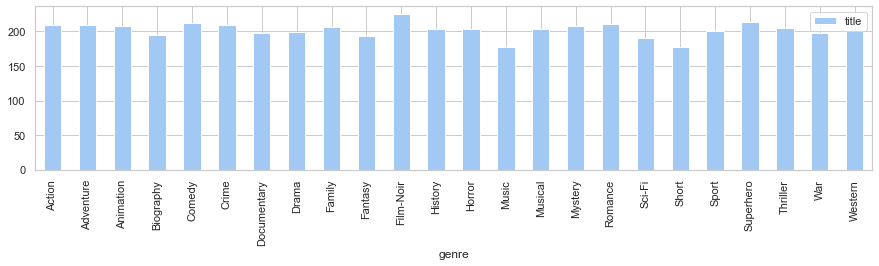

Testing dataset: 1620


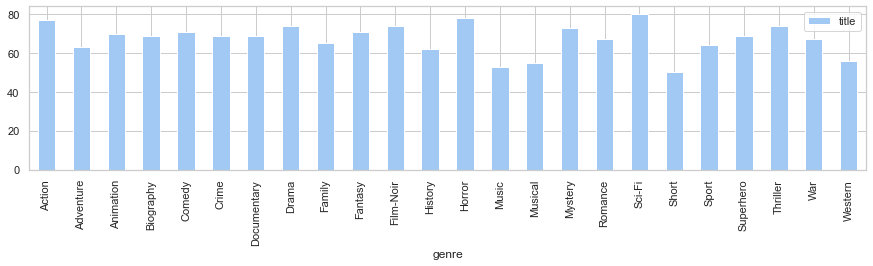

In [10]:
print(f"Training dataset: {len(train_data)}")
train_data.pivot_table(index="genre", values="title", aggfunc="count").plot(kind="bar", figsize=(15, 3))
plt.show()

print(f"Testing dataset: {len(test_dataset)}")
test_data.pivot_table(index="genre", values="title", aggfunc="count").plot(kind="bar", figsize=(15, 3))
plt.show()

In [11]:
def mobilenet_v2(pretrained: bool = True, freeze: bool = False) -> nn.Module:
    model = torchvision.models.mobilenet_v2(pretrained=pretrained)
    
    # Unfreeze he last 4 layers.
    if freeze:
        for child in list(model.features)[:-4]:
            for param in child.parameters():
                param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Linear(1280, 500),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(500, 24)
    )
    
    return model

In [12]:
model = mobilenet_v2(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
runner = dl.SupervisedRunner(
    input_key="features", output_key="logits", target_key="targets", loss_key="loss"
)

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=25,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5)),
    ],
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
)

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Synopsis Classification
        </p>
    </a>
</blockquote>

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from torch import Tensor
import sklearn

In [5]:
dataset = pd.read_csv("imdb_dataset.csv")
train_data, test_data = train_test_split(dataset, train_size=0.75, shuffle=True)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [6]:
train_data = train_data[["synopsis", "label"]].rename({"synopsis": "text"}, axis=1)
test_data = test_data[["synopsis", "label"]].rename({"synopsis": "text"}, axis=1)

In [7]:
train_dataset = Dataset.from_pandas(train_data, split="train")
test_dataset = Dataset.from_pandas(test_data, split="test")

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples: str) -> Tensor:
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=24)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [9]:
# Building fuction for metrics calculation.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=labels)
    f1 = sklearn.metrics.f1_score(y_pred=predictions, y_true=labels, average="weighted")
    
    return {
        "accuracy": accuracy,
        "f1": f1,
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=25,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Title Classification
        </p>
    </a>
</blockquote>

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from torch import Tensor
import sklearn

In [5]:
dataset = pd.read_csv("imdb_dataset.csv")
train_data, test_data = train_test_split(dataset, train_size=0.75, shuffle=True)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [6]:
train_data = train_data[["title", "label"]].rename({"title": "text"}, axis=1)
test_data = test_data[["title", "label"]].rename({"title": "text"}, axis=1)

In [7]:
train_dataset = Dataset.from_pandas(train_data, split="train")
test_dataset = Dataset.from_pandas(test_data, split="test")

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples: str) -> Tensor:
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=24)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [9]:
# Building fuction for metrics calculation.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = sklearn.metrics.accuracy_score(y_pred=predictions, y_true=labels)
    f1 = sklearn.metrics.f1_score(y_pred=predictions, y_true=labels, average="weighted")
    
    return {
        "accuracy": accuracy,
        "f1": f1,
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_titles",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=25,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Validation
        </p>
    </a>
</blockquote>

Plots for a text network for synopsis prediction.

In [10]:
val_loss = [
    3.021200,
    2.635800,
    2.170500,
    1.627500,
    1.129500,
    0.675200,
    0.387800,
    0.208500,
    0.130700,
    0.088000,
    0.066100,
    0.061900,
    0.049200,
    0.053400,
    0.040500,
    0.039000,
    0.043900,
    0.032800,
    0.037100,
    0.027500,
    0.022600,
    0.024000,
    0.020300,
    0.016200,
    0.013700
]



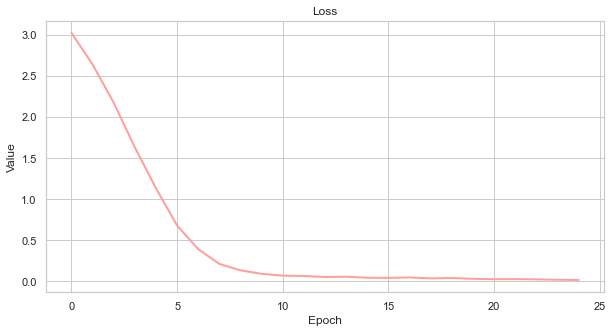

In [11]:
def plot(val_data, title):
    figure = plt.figure(figsize=(10, 5))
    
    plt.plot(val_data, linewidth=2, color="r")
    
    plt.ylabel("Value")
    plt.xlabel("Epoch")
    plt.title(title)
    plt.show()

plot(val_data=val_loss, title="Loss")

Plots for a convolutional network for poster class prediction.

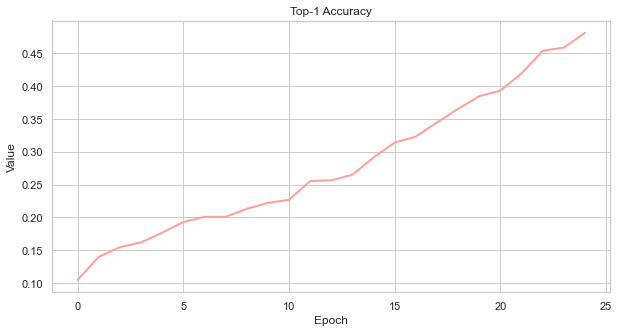

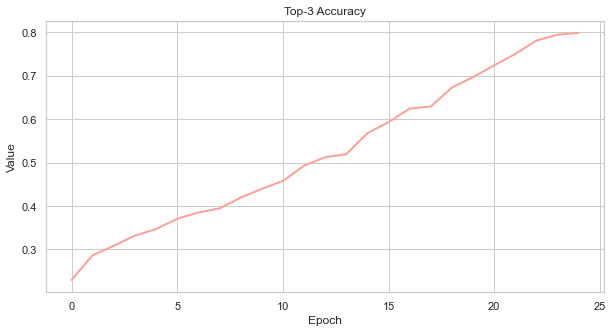

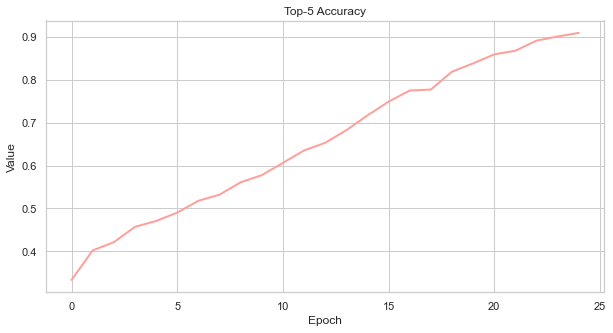

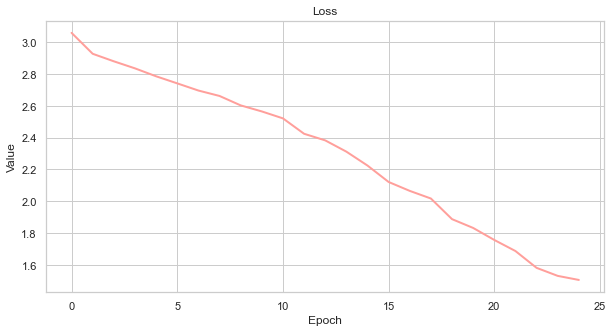

In [12]:
val_cnn = pd.read_csv("valid_mobilenet.csv")
plot(val_data=val_cnn["accuracy01"], title="Top-1 Accuracy")
plot(val_data=val_cnn["accuracy03"], title="Top-3 Accuracy")
plot(val_data=val_cnn["accuracy05"], title="Top-5 Accuracy")
plot(val_data=val_cnn["loss"], title="Loss")

In [15]:
model = mobilenet_v2(pretrained=False)
device = torch.device("cpu")

checkpoint = torch.load("logs/checkpoints/model.last.pth", map_location=device)
model.load_state_dict(checkpoint, strict=True)

model = model.eval()

In [16]:
classes = [
    "Romance", "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary",
    "Drama", "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Superhero",
    "Musical", "Mystery", "Sci-Fi", "Sport", "Thriller", "War", "Western", "Short"
]

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transforms = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

def predict(image: np.ndarray) -> torch.Tensor:
    image = nhwc_to_nchw(torch.Tensor(image))
    image = image.to(device)
    output = model(image)
    return output

In [17]:
def test_shap(image):
    X = transforms(torch.Tensor(image).unsqueeze(0)).to(device)
    output = predict(X)
    labels = torch.argmax(output, axis=1).cpu().numpy()
    print(f"Classes: {labels}: {np.array(classes)[labels]}")

    topk = 5
    batch_size = 32
    n_evals = 500

    masker_blur = shap.maskers.Image("blur(224,224)", X[0].shape)
    explainer = shap.Explainer(predict, masker_blur, output_names=classes)
    shap_values = explainer(X, max_evals=n_evals, batch_size=batch_size,
                            outputs=shap.Explanation.argsort.flip[:topk])

    shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
    shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)]

    shap.image_plot(shap_values=shap_values.values,
                    pixel_values=shap_values.data,
                    labels=shap_values.output_names,
                    true_labels=[classes[12]])

Classes: [22]: ['Western']


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.43s/it]                                                                            
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


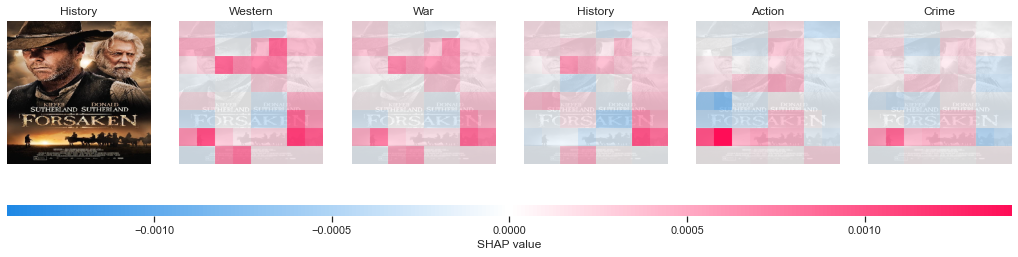

In [18]:
image = np.array(Image.open("test_western.jpg"))
test_shap(image)

Classes: [19]: ['Sport']


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:17, 17.87s/it]                                                                            
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


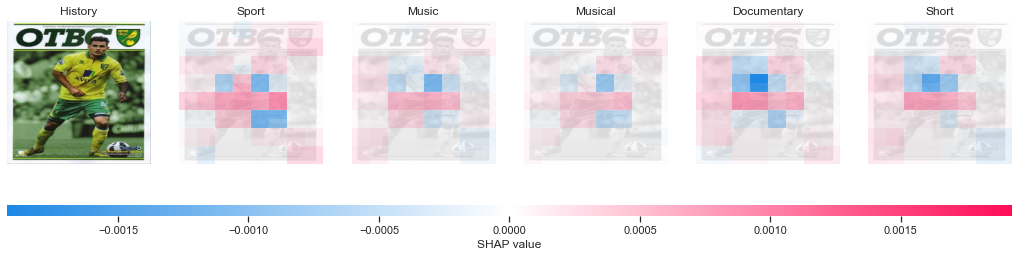

In [19]:
image = np.array(Image.open("test_sport.jpg"))
test_shap(image)

Classes: [17]: ['Mystery']


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.57s/it]                                                                            
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


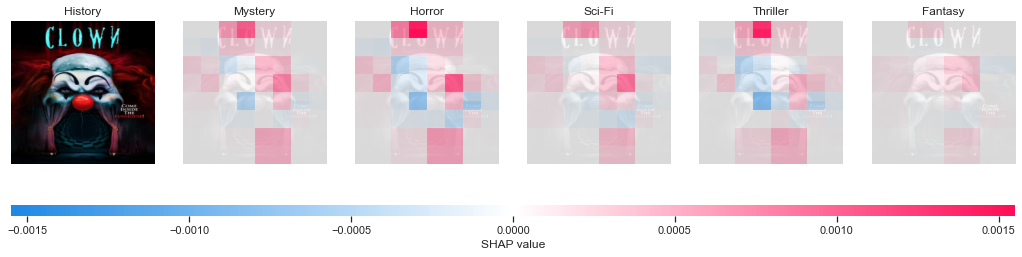

In [20]:
image = np.array(Image.open("test_horror.jpg"))
test_shap(image)

Classes: [10]: ['Fantasy']


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.10s/it]                                                                            
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


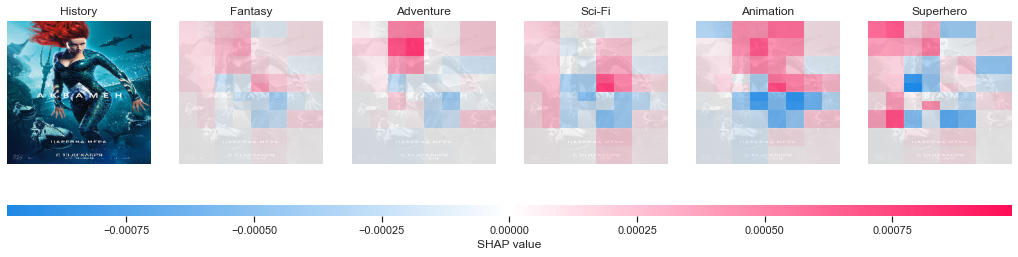

In [21]:
image = np.array(Image.open("test_super.jpg"))
test_shap(image)

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="005" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Multimodal Classification
        </p>
    </a>
</blockquote>

In [4]:
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from torch import Tensor
import sklearn

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class MultiModel(nn.Module):
    def __init__(self, image_model, text_model):
        super(MultiModel, self).__init__()
        
        self.image_model = image_model
        self.image_model.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        
        self.text_model = text_model
        self.text_model.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 24),
            nn.Softmax(dim=0)
        )
    
    def forward(self, image, text):
        image_out = self.image_model(image)
        image_out = image_out.view(-1)
        
        text_out = self.text_model(
            input_ids=text["input_ids"].view(-1, 512).to(device),
            attention_mask=text["attention_mask"].view(-1, 512).to(device)).logits
        text_out = text_out.view(-1)
        
        combined_inp = torch.cat((image_out, text_out))
        
        x = self.classifier(combined_inp)
        
        return x

In [7]:
def mobilenet_v2(pretrained: bool = True, freeze: bool = False) -> nn.Module:
    model = torchvision.models.mobilenet_v2(pretrained=pretrained)
    
    # Unfreeze he last 4 layers.
    if freeze:
        for child in list(model.features)[:-4]:
            for param in child.parameters():
                param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Linear(1280, 500),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(500, 24)
    )
    
    return model

image_model = mobilenet_v2(pretrained=False)
checkpoint = torch.load("logs/checkpoints/model.last.pth", map_location=device)
image_model.load_state_dict(checkpoint, strict=True)
image_model = image_model.eval()

In [8]:
tokenizer = AutoTokenizer.from_pretrained("results_titles\\checkpoint-30375")
text_model = AutoModelForSequenceClassification.from_pretrained("results_titles\\checkpoint-30375", num_labels=24)
text_model = text_model.eval()

In [9]:
model = MultiModel(image_model, text_model).to(device)

In [10]:
class MultiDataset(Dataset):
    def __init__(self, annotation: pd.DataFrame, transforms: callable | None = None) -> None:
        """
        Args:
            annotation (pd.DataFrame): Pandas dataframe with annotation.
            transform (callable, optional): Optional transform object.
        """
        self.annotation = annotation
        self.transforms = transforms
    
    def __len__(self) -> int:
        return len(self.annotation)
    
    def __getitem__(self, index: int) -> dict:
        image_name = self.annotation.loc[index, "poster_path"]
        image = Image.open(image_name).convert("RGB")
        
        synopsis = self.annotation.loc[index, "synopsis"]
        synopsis = tokenizer(synopsis, padding="max_length", max_length=512, return_tensors="pt", truncation=True)
        
        label = self.annotation.loc[index, "label"].astype(torch.FloatTensor)
        
        sample = {"image": image, "synopsis": synopsis, "targets": label}
        
        # Image augmentation is recommended.
        # See more: https://pytorch.org/vision/master/transforms.html.
        if self.transforms:
            sample = {"features": self.transforms(image), "synopsis": synopsis, "targets": label}
        
        return sample

In [11]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dataset = pd.read_csv("imdb_dataset.csv")
train_data, test_data = train_test_split(dataset, train_size=0.75, shuffle=True)

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

train_dataset = MultiDataset(annotation=train_data, transforms=transforms)
test_dataset = MultiDataset(annotation=test_data, transforms=transforms)

loaders = {
    "train": torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, drop_last=True),
    "valid": torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, drop_last=True),
}

In [12]:
def metrics(model, dataloader, loss_function, device):
    acc_log = 0
    loss_log = 0
    num_examples = 0
    
    for index, batch in enumerate(dataloader):
        image, text, target = batch["features"], batch["synopsis"], batch["targets"]
        image, target = image.to(device), target.to(device)
        
        logits = model(image=image, text=text)
        
        loss = loss_function(logits.float().requires_grad_(), target.squeeze(0))
        loss_log = loss_log + loss.item()
        
        predicted = logits.argmax(keepdims=True)
        acc_log = acc_log + (predicted == target).sum()
        
        num_examples = num_examples + target.size(0)
    
    return acc_log.detach().cpu().numpy() / num_examples * 100, loss_log / num_examples

In [13]:
def checkpoint(model):
    torch.save(
        {'state_dict': model.state_dict()},
        '{}.pth'.format(type(model).__name__)
    )

In [14]:
def train(model, train_dataloader, test_dataloader, device):
    acc_log = np.array([])
    loss_log = np.array([])
    error = 0
    
    start_time = time.time()
    
    for epoch in range(5):
        epoch_start = time.time()
        
        model.train()
        
        for index, batch in enumerate(train_dataloader):
            image, text, target = batch["features"], batch["synopsis"], batch["targets"]
            image, target = image.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            logits = model(image=image, text=text)
            loss = loss_function(logits.float().requires_grad_(), target.squeeze(0))
            
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        with torch.no_grad():
            cur_acc, cur_loss = metrics(
                model=model,
                dataloader=test_dataloader,
                loss_function=loss_function,
                device=device
            )
            
            acc_log = np.append(acc_log, cur_acc)
            loss_log = np.append(loss_log, cur_loss)
        
        epoch_end = time.time() - epoch_start
        
        print(
            'EPOCH: {}'.format(epoch),
            'ACC: {:.0f}%'.format(cur_acc),
            'LOSS: {:.4f}'.format(cur_loss),
            'TIME: {:.2f}'.format(epoch_end/60)
        )
        
        if cur_acc > error:
            error = cur_loss
            
            checkpoint(model=model)
    
    total_time = time.time() - start_time
    print('TOTAL TIME: {:.2f} min'.format(total_time/60))
    
    return acc_log, loss_log

In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

In [ ]:
acc_log, loss_log = train(model, loaders["train"], loaders["valid"], device)